# Import Libraries

In [95]:
import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

plt.style.use('seaborn')
sns.set(font_scale=2.0)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [96]:
# 자릿수 설정
pd.set_option('display.float_format', '{:,.0f}'.format)

# Load Dataset

In [97]:
df_train = pd.read_csv('data/movies_train.csv')
df_test = pd.read_csv('data/movies_test.csv')

In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [99]:
df_train.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,"1,161,602",2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,"220,775",4,343,4,6959083


In [100]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [101]:
df_test.head(3)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,"300,529",2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,"342,700",4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,"4,206,611",3,419,7


# Explore Dataset
- 이번에는 train, test 데이터를 합치지 않고 따로따로 처리하도록 한다.
- 처음부터 합쳐서 전처리하고 나중에 다시 나누는 게 훨씬 편함.

## 결측치 확인

In [102]:
df_train.shape, df_test.shape

((600, 12), (243, 11))

In [103]:
df_train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [104]:
df_test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [105]:
# 처리는 나중에 데이터 살펴보고 나서 진행

## label 확인 : box_off_num
- Label, 관객 수

In [106]:
df_train[['box_off_num']].describe()

,box_off_num
count,600
mean,"708,182"
std,"1,828,006"
min,1
25%,"1,297"
50%,"12,591"
75%,"479,887"
max,"14,262,766"


<AxesSubplot:>

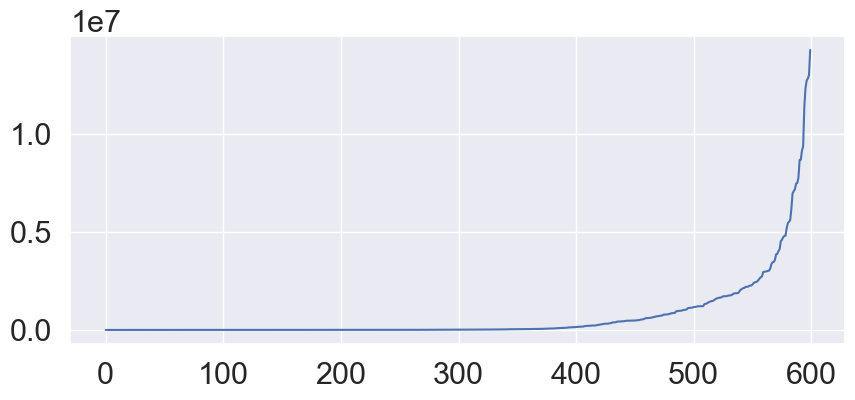

In [107]:
df_train['box_off_num'].sort_values().reset_index(drop=True).plot(figsize=(10, 4))

## 상관분석

In [108]:
heatmap_data = df_train[['time','dir_prev_num','num_staff','num_actor','box_off_num']]

In [109]:
heatmap_data.corr()

,time,dir_prev_num,num_staff,num_actor,box_off_num
time,1,0,1,0,0
dir_prev_num,0,1,0,0,0
num_staff,1,0,1,0,1
num_actor,0,0,0,1,0
box_off_num,0,0,1,0,1


<AxesSubplot:title={'center':'Pearson Correalation of Features'}>

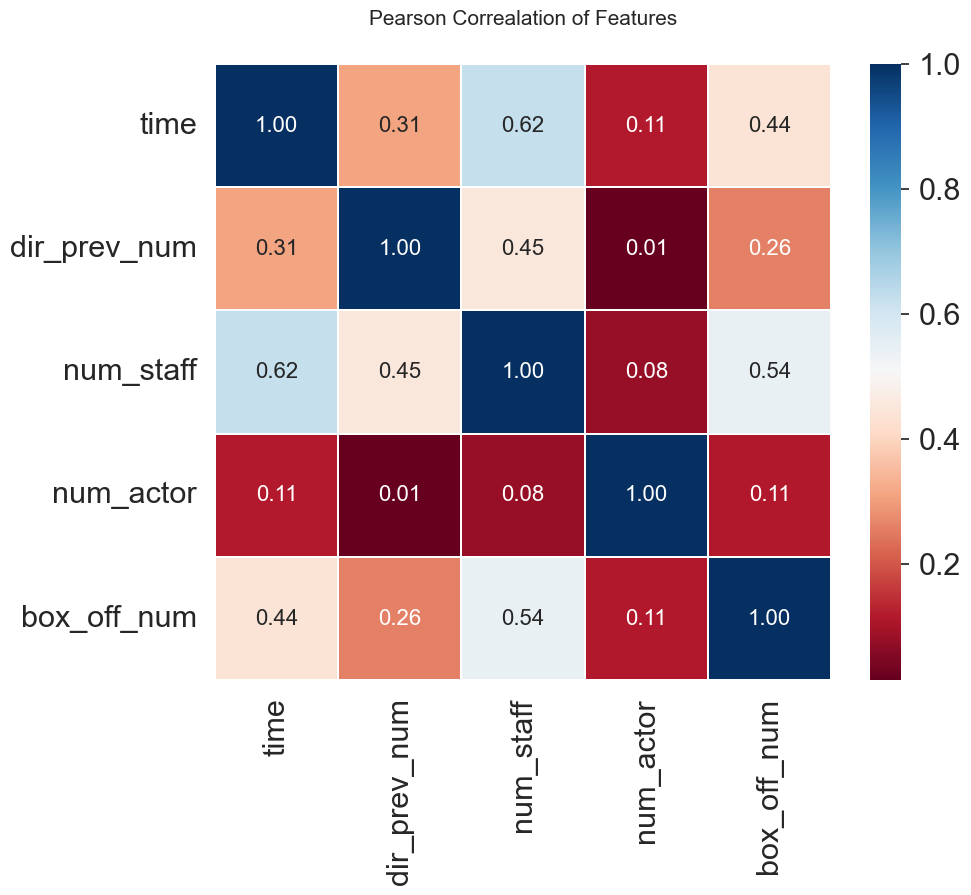

In [110]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 8))

plt.title('Pearson Correalation of Features', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0
            , square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16}, fmt='.2f')

## title
- 제목

In [111]:
# 영화 제목은 모두 달라서 의미를 찾아내기 어려우므로 삭제
len(df_train['title'].unique())

600

In [112]:
# 혹시 영화 제목의 길이와 관객 수 사이에 상관관계가 있을까?

result = []
for i in range(0, 600):
    word_length = len(df_train['title'][i])
    result.append(word_length)

print(result)

[6, 4, 9, 8, 4, 14, 4, 3, 15, 5, 6, 5, 2, 1, 7, 6, 2, 8, 2, 3, 9, 11, 2, 6, 6, 2, 6, 17, 3, 16, 6, 4, 6, 7, 6, 8, 6, 3, 8, 4, 8, 5, 6, 17, 4, 8, 5, 7, 3, 26, 2, 3, 24, 12, 2, 7, 3, 7, 7, 4, 27, 4, 4, 2, 11, 4, 3, 10, 20, 7, 8, 9, 6, 17, 3, 13, 7, 3, 7, 5, 2, 6, 2, 4, 5, 6, 3, 4, 13, 3, 4, 3, 18, 7, 6, 2, 3, 3, 6, 8, 3, 2, 2, 7, 3, 2, 1, 9, 5, 5, 3, 2, 18, 8, 3, 4, 6, 14, 7, 4, 8, 3, 3, 10, 2, 17, 7, 6, 17, 3, 20, 3, 6, 2, 4, 7, 8, 6, 2, 3, 5, 15, 6, 2, 12, 5, 2, 5, 5, 1, 7, 14, 2, 6, 11, 4, 7, 2, 5, 22, 4, 5, 2, 8, 11, 5, 3, 9, 2, 6, 4, 16, 2, 8, 9, 9, 8, 3, 16, 3, 10, 4, 2, 17, 4, 4, 3, 8, 12, 3, 6, 21, 4, 4, 4, 12, 8, 2, 15, 9, 4, 7, 8, 8, 19, 8, 8, 15, 2, 2, 4, 9, 5, 4, 4, 9, 6, 2, 6, 8, 3, 2, 2, 3, 10, 4, 7, 8, 2, 9, 6, 13, 8, 11, 4, 9, 7, 2, 5, 14, 6, 7, 5, 4, 9, 7, 2, 7, 9, 2, 8, 2, 9, 5, 3, 9, 5, 6, 3, 3, 13, 3, 11, 7, 10, 16, 8, 15, 7, 2, 7, 9, 4, 3, 6, 7, 2, 12, 2, 3, 10, 6, 2, 5, 7, 12, 4, 9, 2, 8, 7, 3, 8, 2, 5, 6, 3, 10, 4, 4, 6, 10, 8, 2, 9, 10, 8, 8, 3, 6, 6, 17, 1, 11, 1

In [113]:
df_train_title = df_train.copy()
df_train_title['title_length'] = result
df_train_title.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,title_length
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,6
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,"1,161,602",2,387,3,7072501,4
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,"220,775",4,343,4,6959083,9
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,"23,894",2,20,6,217866,8
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1,1,251,2,483387,4


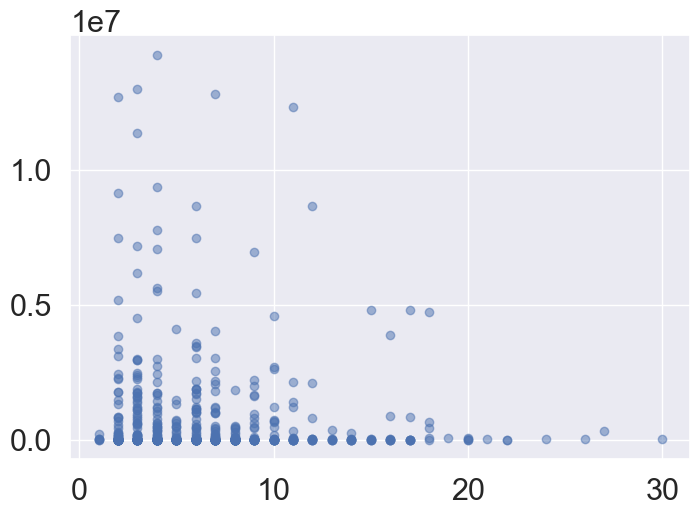

In [114]:
plt.scatter(x=df_train_title['title_length'], y=df_train_title['box_off_num'], alpha=0.5)

In [115]:
# 상관분석 결과 -0.08로 큰 의미가 없을 것 같다.
title_box_corr = df_train_title[['title_length','box_off_num']].corr(method='pearson')
title_box_corr

,title_length,box_off_num
title_length,1,-0
box_off_num,-0,1


<AxesSubplot:>

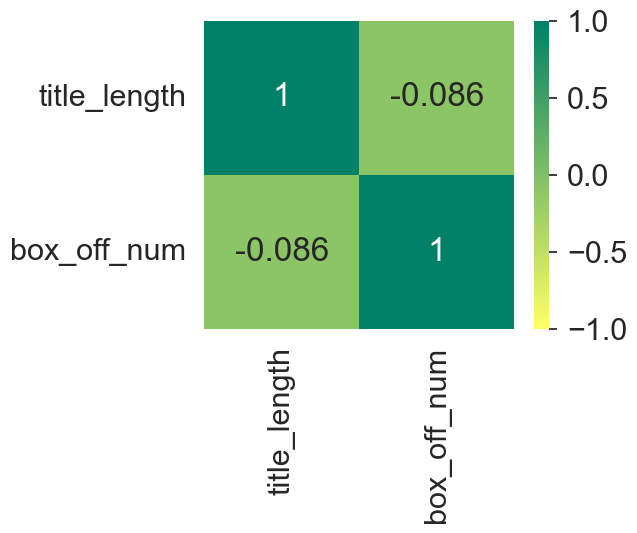

In [116]:
f, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.heatmap(title_box_corr,
           annot = True,
           cmap = 'summer_r', 
           vmin = -1, vmax=1)

In [117]:
# 컬럼 삭제
df_train = df_train.drop('title', axis=1)
df_test = df_test.drop('title', axis=1)

## distributor
- 배급사

In [118]:
# unique를 찍어보면 역시나 엄청 많다
len(df_train['distributor'].unique())

169

- 배급사는 169개가 있으므로, title과 달리 배급사와 영화는 일대다 관계
- 1) 과거 배급 영화 수가 배급사의 파워(순위)를 결정하는 요소일 수 있다.
- 2) 과거 많은 관객을 모은 배급사일수록 향후에도 많은 관객을 모을 것으로 기대할 수 있다.

In [119]:
# 배급사별 영화 수 확인
# 1, 2위가 압도적이고 3-6위가 그 다음이다.
df_train_dist_cnt = pd.DataFrame(df_train['distributor'].value_counts())
df_train_dist_cnt.head(10)

,distributor
CJ 엔터테인먼트,54
롯데엔터테인먼트,52
(주)NEW,30
(주)마운틴픽쳐스,29
(주)쇼박스,26
인디스토리,26
골든타이드픽처스,15
(주) 케이알씨지,14
(주) 영화사조제,10
영화사 진진,10


In [120]:
# 배급사별 관객 수 확인
# 5위부터는 급격히 감소한다.
df_train_dist_sum = pd.DataFrame(df_train.groupby('distributor')['box_off_num'].sum().sort_values(ascending=False))
df_train_dist_sum.head(10)

,box_off_num
distributor,
CJ 엔터테인먼트,116788093
(주)쇼박스,88053064
(주)NEW,65532145
롯데엔터테인먼트,64383745
CJ E&M Pictures,8244674
NEW,8152133
CJ E&M 영화부문,7515928
CGV아트하우스,6590943
시네마서비스,5381059


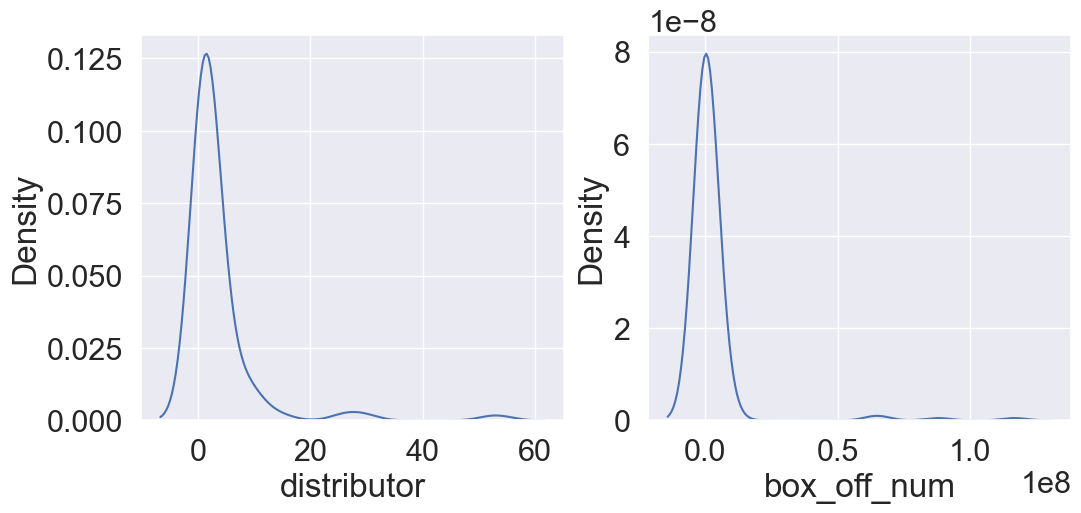

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df_train_dist_cnt['distributor'], ax=ax[0])

sns.kdeplot(df_train_dist_sum['box_off_num'], ax=ax[1])

plt.show()

In [122]:
# 1)를 선택하고 상위 5개 배급사 외에는 기타로 처리한다.

distributor_list = df_train_dist_cnt[:5]

def distributor_agg(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

df_train['distributor'] = df_train['distributor'].apply(lambda x : distributor_agg(x))
df_test['distributor'] = df_test['distributor'].apply(lambda x : distributor_agg(x))

In [123]:
# # 2)를 선택하고 상위 4개 배급사 외에는 기타로 처리한다.

# distributor_list = df_train_dist_sum[:4]

# def distributor_agg(distributor):
#     if distributor in distributor_list:
#         return distributor
#     else:
#         return '기타'

# df_train['distributor'] = df_train['distributor'].apply(lambda x : distributor_agg(x))
# df_test['distributor'] = df_test['distributor'].apply(lambda x : distributor_agg(x))

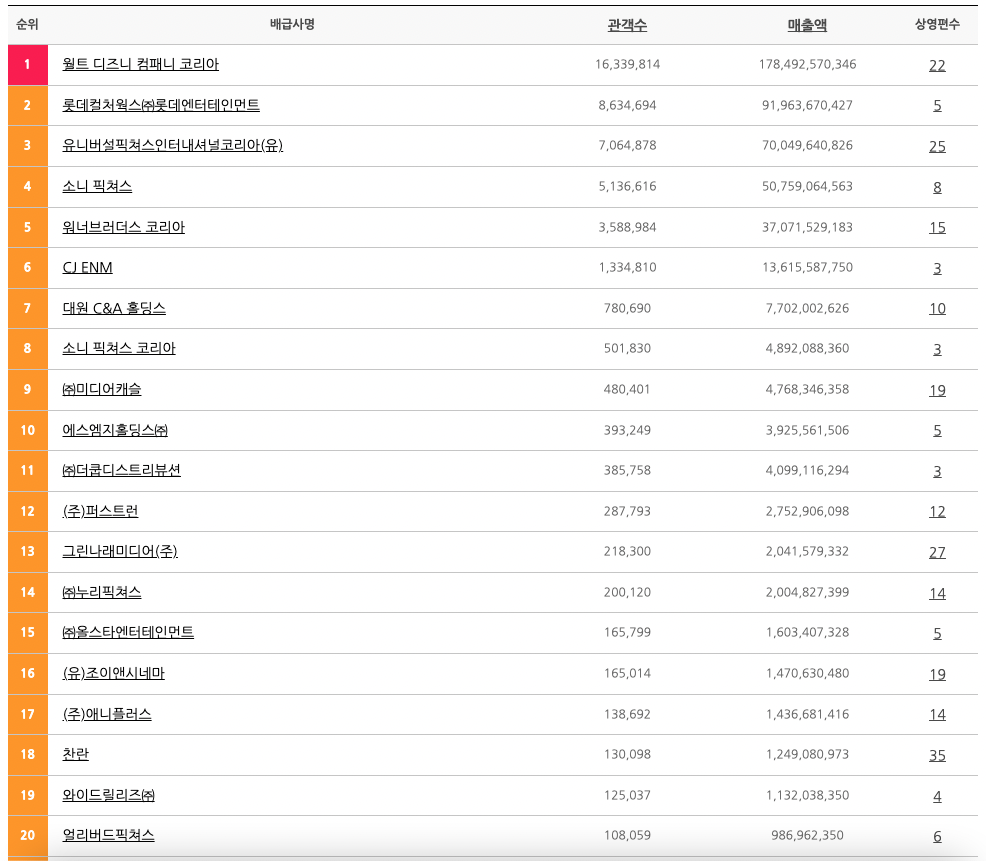

In [124]:
# 번외
# 실제로 지금 시점의 데이터 분석을 한다면 국내 배급사 매출 순위와 일치하는지 확인해보는 것도 방법이다.
# http://www.cine21.com/rank/boxoffice/company/?cs_type=distributor
# 씨네21에서 2022-12-22 기준 1년 MAT로 확인해 본 배급사 순위는 아래와 같다.
Image('distributor_ranking_22-12.png')

## genre
- 장르는 취향의 차이이므로 관객 수와의 상관관계는 낮을 것으로 생각된다.
- 다만, 액션이나 드라마 같은 장르는 비교적 대중적이므로 스릴러와 같은 장르에 비해서는 더 인기가 있을 것으로 생각되는데 확인해보자.

In [125]:
df_train['genre'].unique()

array(['액션', '느와르', '코미디', '다큐멘터리', '뮤지컬', '드라마', '멜로/로맨스', '공포', '서스펜스',
       '애니메이션', '미스터리', 'SF'], dtype=object)

- 대략 다 다른 것 같아 보이지만 공포, 서스펜스 같은 장르는 비슷해서 묶을 수 있을 것 같다.

In [126]:
df_train['genre'].value_counts()

드라마       221
다큐멘터리      93
멜로/로맨스     78
코미디        53
공포         42
액션         28
느와르        27
애니메이션      21
미스터리       17
SF         13
뮤지컬         5
서스펜스        2
Name: genre, dtype: int64

- 미스터리, SF, 뮤지컬, 서스펜스는 데이터 갯수가 적다.
- 액션과 느와르는 같이 묶어도 될 것 같다.
- 영화라는 예술 관점에서 봤을 때는 모든 장르가 하나하나 뚜렷한 특색을 가진다. 하지만 우리가 예측하려는 label은 '영화 관객 수'인데, 관객들은 영화를 볼 때 그렇게까지 세분화해서 장르를 구분하지 않을 것 같다. 영화를 보러 가는 이유와 TPO를 고려하여 비슷한 것끼리 묶어도 될 것 같다.

## release_time
- 개봉일
- 영화 흥행에 개봉 일정은 매우 중요한 요소이다. 이 데이터에서 개봉일이 어떤 계절성을 가지는지 알아보자.

In [127]:
df_train_time = df_train[['release_time','box_off_num']].set_index('release_time').sort_index()
df_train_time

,box_off_num
release_time,
2010-01-02,353
2010-01-14,791
2010-01-14,143458
2010-01-14,27083
2010-01-14,155281
...,...
2015-12-17,1599
2015-12-24,329
2015-12-30,627586


<AxesSubplot:xlabel='release_time'>

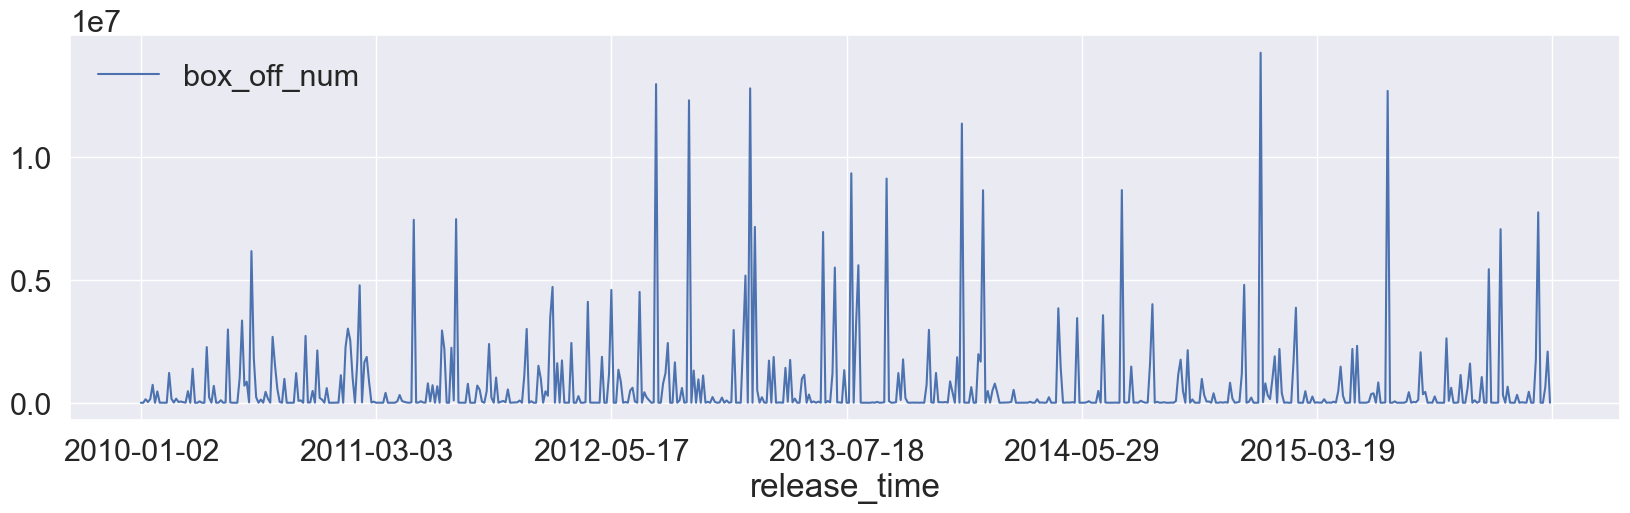

In [128]:
df_train_time.plot(figsize=(20, 5))

- 이렇게 일자별로 보니 알 수가 없다. 월별로 묶어 보자

In [129]:
df_train_time['datetime'] = pd.to_datetime(df_train_time.index)
df_train_time['year'] = df_train_time['datetime'].dt.year
df_train_time['month'] = df_train_time['datetime'].dt.month
df_train_time['day'] = df_train_time['datetime'].dt.day_name()
df_train_time['yearmonth'] = df_train_time['datetime'].dt.to_period('M')
df_train_time

,box_off_num,datetime,year,month,day,yearmonth
release_time,,,,,,
2010-01-02,353,2010-01-02,2010,1,Saturday,2010-01
2010-01-14,791,2010-01-14,2010,1,Thursday,2010-01
2010-01-14,143458,2010-01-14,2010,1,Thursday,2010-01
2010-01-14,27083,2010-01-14,2010,1,Thursday,2010-01
2010-01-14,155281,2010-01-14,2010,1,Thursday,2010-01
...,...,...,...,...,...,...
2015-12-17,1599,2015-12-17,2015,12,Thursday,2015-12
2015-12-24,329,2015-12-24,2015,12,Thursday,2015-12
2015-12-30,627586,2015-12-30,2015,12,Wednesday,2015-12


In [130]:
# 연도 테이블
df_year = df_train_time.groupby('year')[['box_off_num']].sum().reset_index()
df_year

,year,box_off_num
0,2010,48749235
1,2011,50309371
2,2012,83223817
3,2013,95698992
4,2014,75423331
5,2015,71504305


In [131]:
# 월별 테이블
df_yearmonth = df_train_time.groupby(['yearmonth','year','month'])[['box_off_num']].sum().reset_index()
df_yearmonth

,yearmonth,year,month,box_off_num
0,2010-01,2010,1,1520657
1,2010-02,2010,2,10232
2,2010-03,2010,3,1548312
3,2010-04,2010,4,1964416
4,2010-05,2010,5,3357253
...,...,...,...,...
67,2015-08,2015,8,3054825
68,2015-09,2015,9,4028216
69,2015-10,2015,10,4564507
70,2015-11,2015,11,13513754


In [132]:
df_yearmonth[df_yearmonth['year'] == 2010]

,yearmonth,year,month,box_off_num
0,2010-01,2010,1,1520657
1,2010-02,2010,2,10232
2,2010-03,2010,3,1548312
3,2010-04,2010,4,1964416
4,2010-05,2010,5,3357253
5,2010-06,2010,6,2998743
6,2010-07,2010,7,5933593
7,2010-08,2010,8,8352713
8,2010-09,2010,9,6434789
9,2010-10,2010,10,4112059


In [133]:
# 요일별 테이블
df_day = df_train_time.groupby('day')[['box_off_num']].sum().reset_index()
df_day = df_day.reindex([1, 4, 5, 3, 0, 2], axis='index')
df_day

,day,box_off_num
1,Monday,1736
4,Tuesday,5183138
5,Wednesday,239433802
3,Thursday,180192720
0,Friday,97302
2,Saturday,353


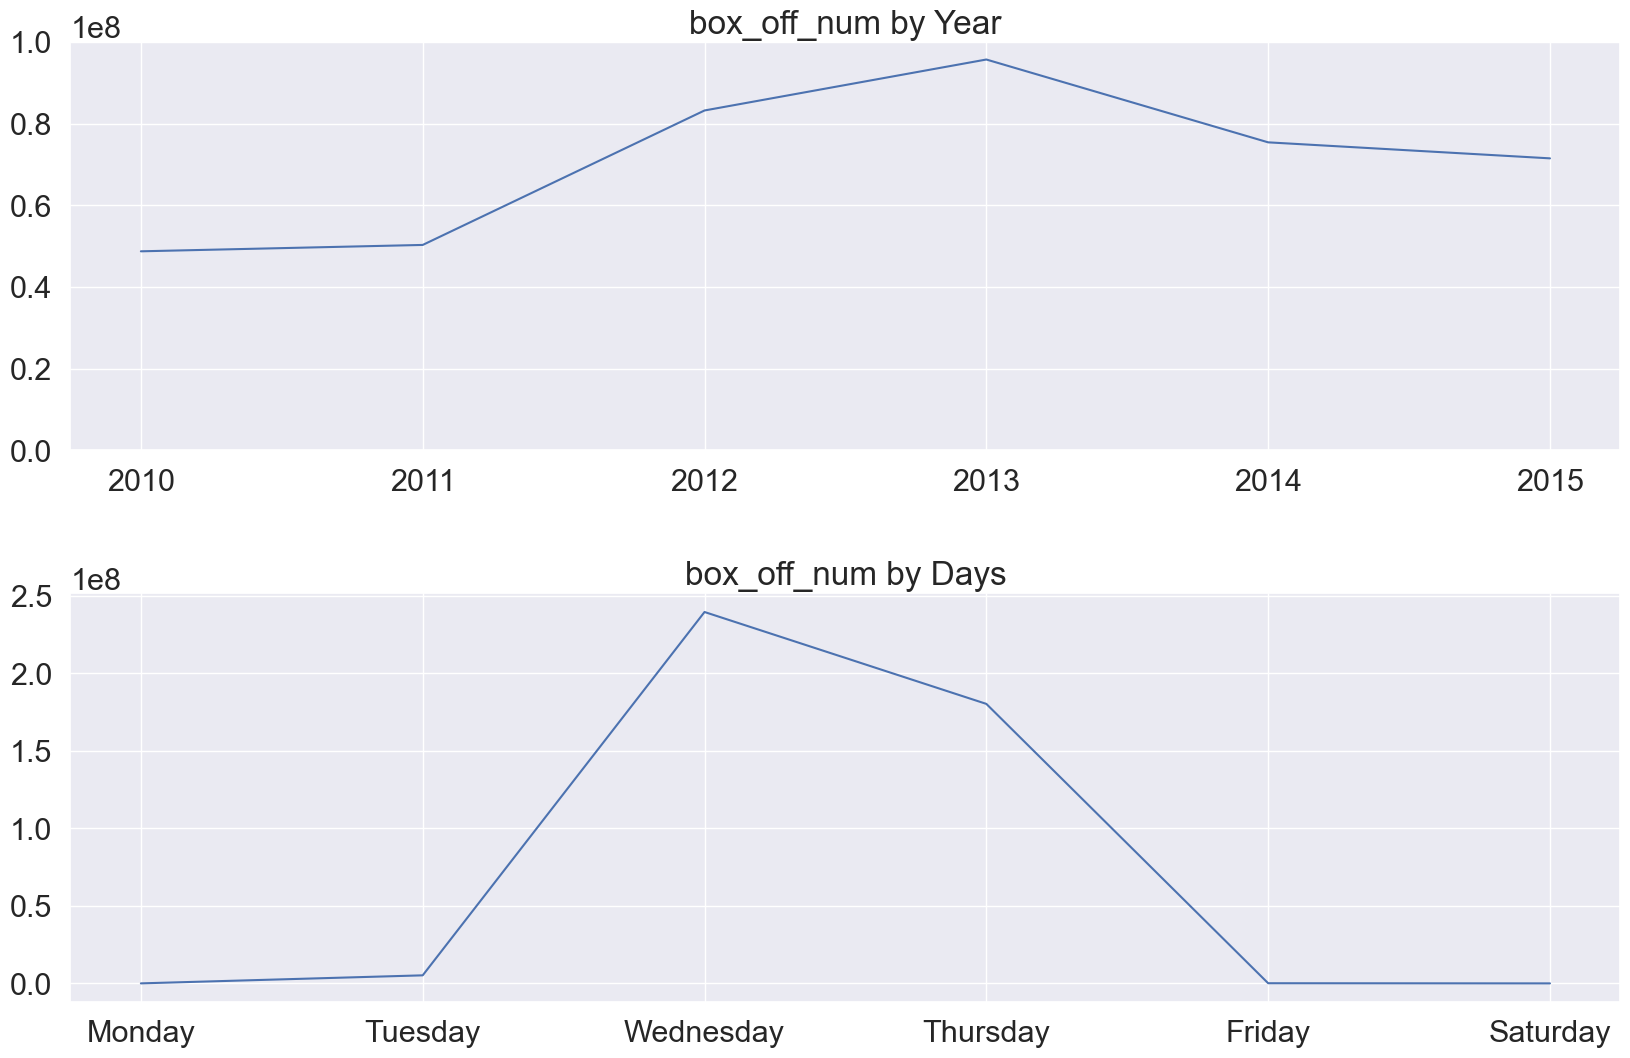

In [134]:
# year, day 시각화
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

ax[0].plot(df_year['year'], df_year['box_off_num'])
ax[0].set_title('box_off_num by Year')
ax[0].set_ylim(0,100000000)

ax[1].plot(df_day['day'], df_day['box_off_num'])
ax[1].set_title('box_off_num by Days')

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.show()

- 연도별로 계절성이 드러난다. 2013년에 정점을 찍고 2014년부터 감소하는 추세이다. 다만, 경제 환경과 영화 산업 등 외부 요인에 따른 가능성도 있을 수 있으므로 연도가 큰 의미를 가진다고 보기 어려울 수도 있다.
- 요일별로는 확연히 차이가 나므로, 개봉일에 따라 영화 관객 수를 예측하는 데 도움이 될 것이다. 수~목요일에 영화가 개봉하므로 가장 관객 수가 많다.

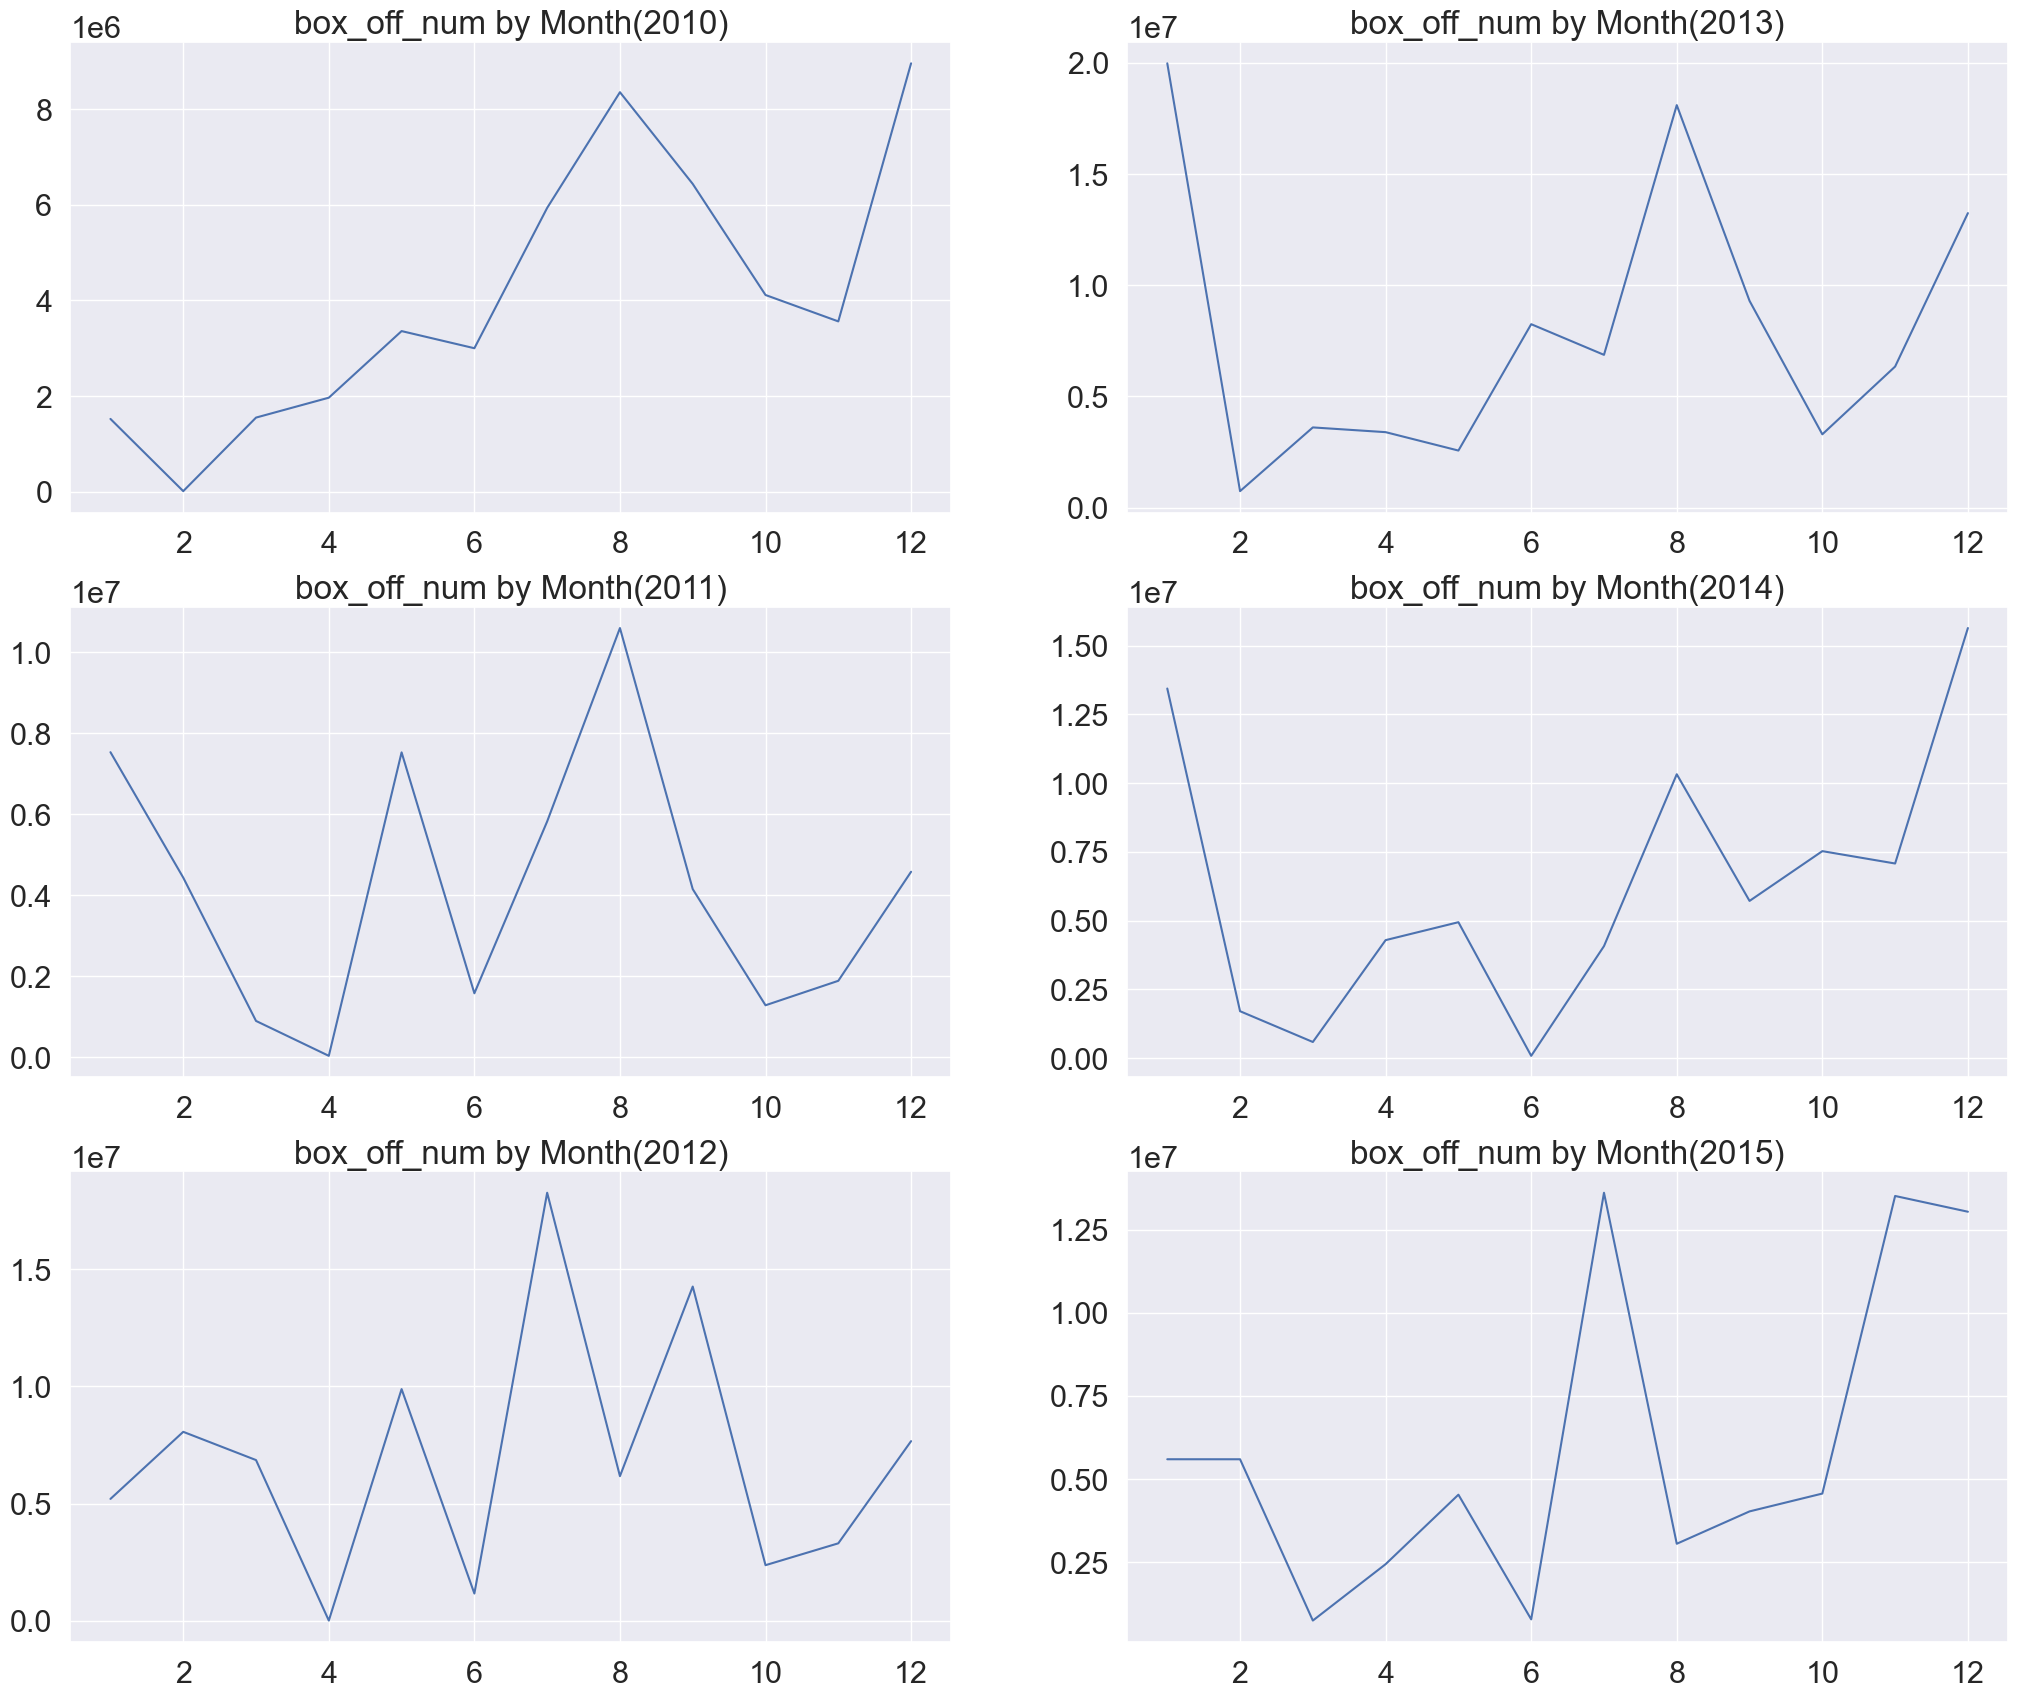

In [135]:
# yearmonth 시각화
fig, ax = plt.subplots(3, 2, figsize=(25, 20))

ax[0,0].plot(df_yearmonth[df_yearmonth['year'] == 2010]['month'], df_yearmonth[df_yearmonth['year'] == 2010]['box_off_num'])
ax[0,0].set_title('box_off_num by Month(2010)')

ax[1,0].plot(df_yearmonth[df_yearmonth['year'] == 2011]['month'], df_yearmonth[df_yearmonth['year'] == 2011]['box_off_num'])
ax[1,0].set_title('box_off_num by Month(2011)')

ax[2,0].plot(df_yearmonth[df_yearmonth['year'] == 2012]['month'], df_yearmonth[df_yearmonth['year'] == 2012]['box_off_num'])
ax[2,0].set_title('box_off_num by Month(2012)')

ax[0,1].plot(df_yearmonth[df_yearmonth['year'] == 2013]['month'], df_yearmonth[df_yearmonth['year'] == 2013]['box_off_num'])
ax[0,1].set_title('box_off_num by Month(2013)')

ax[1,1].plot(df_yearmonth[df_yearmonth['year'] == 2014]['month'], df_yearmonth[df_yearmonth['year'] == 2014]['box_off_num'])
ax[1,1].set_title('box_off_num by Month(2014)')

ax[2,1].plot(df_yearmonth[df_yearmonth['year'] == 2015]['month'], df_yearmonth[df_yearmonth['year'] == 2015]['box_off_num'])
ax[2,1].set_title('box_off_num by Month(2015)')

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(22, 8))

for i in range(2010, 2016):
    plt.plot(df_yearmonth[df_yearmonth['year'] == i]['month'], df_yearmonth[df_yearmonth['year'] == i]['box_off_num'])

plt.title('box_off_num by Month')

plt.show()

- 월별로 봤을 때는 12-1월, 7-8월에 높은 것으로 나타난다.
- 날씨가 너무 덥거나 추울 때 사람들은 실내에 있는 영화관을 많이 찾게 되는걸까?

In [136]:
# 일단 year, month 칼럼 추가해 주고 기존에 있는 release_time은 삭제한다.

In [137]:
# year 컬럼 추가
df_train['year'] = pd.to_datetime(df_train['release_time']).dt.year
df_test['year'] = pd.to_datetime(df_test['release_time']).dt.year

In [138]:
# month 컬럼 추가
df_train['month'] = pd.to_datetime(df_train['release_time']).dt.month
df_test['month'] = pd.to_datetime(df_test['release_time']).dt.month

In [139]:
# drop
df_train = df_train.drop('release_time', axis=1)
df_test = df_test.drop('release_time', axis=1)

## time
- 상영시간 (분)
- 상영시간은 분포에 따라 1분 단위로 달라진다기보다는, 심리적 저항선에 따라 달라질 것 같다.
- 가정: 상영시간은 120분을 기준을 초과하는 경우 관객 수가 비교적 적고, 100~120분일 떄 가장 많으며, 100분 미만이면 적을 것 같다. 확인해보자.

In [140]:
df_train.head()

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month
0,기타,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,2012,11
1,기타,느와르,130,청소년 관람불가,우민호,"1,161,602",2,387,3,7072501,2015,11
2,기타,액션,123,15세 관람가,장철수,"220,775",4,343,4,6959083,2013,6
3,기타,코미디,101,전체 관람가,구자홍,"23,894",2,20,6,217866,2012,7
4,기타,코미디,108,15세 관람가,신근호,1,1,251,2,483387,2010,11


In [141]:
df_train_time = df_train[['time','box_off_num']].sort_values('time').reset_index(drop=True)
df_train_time

,time,box_off_num
0,45,2919
1,60,328
2,61,71
3,61,188
4,62,152
...,...,...
595,153,1744585
596,156,2260512
597,163,3350311
598,166,4398


In [142]:
df_train_time.describe()

,time,box_off_num
count,600,600
mean,101,"708,182"
std,18,"1,828,006"
min,45,1
25%,89,"1,297"
50%,100,"12,591"
75%,114,"479,887"
max,180,"14,262,766"


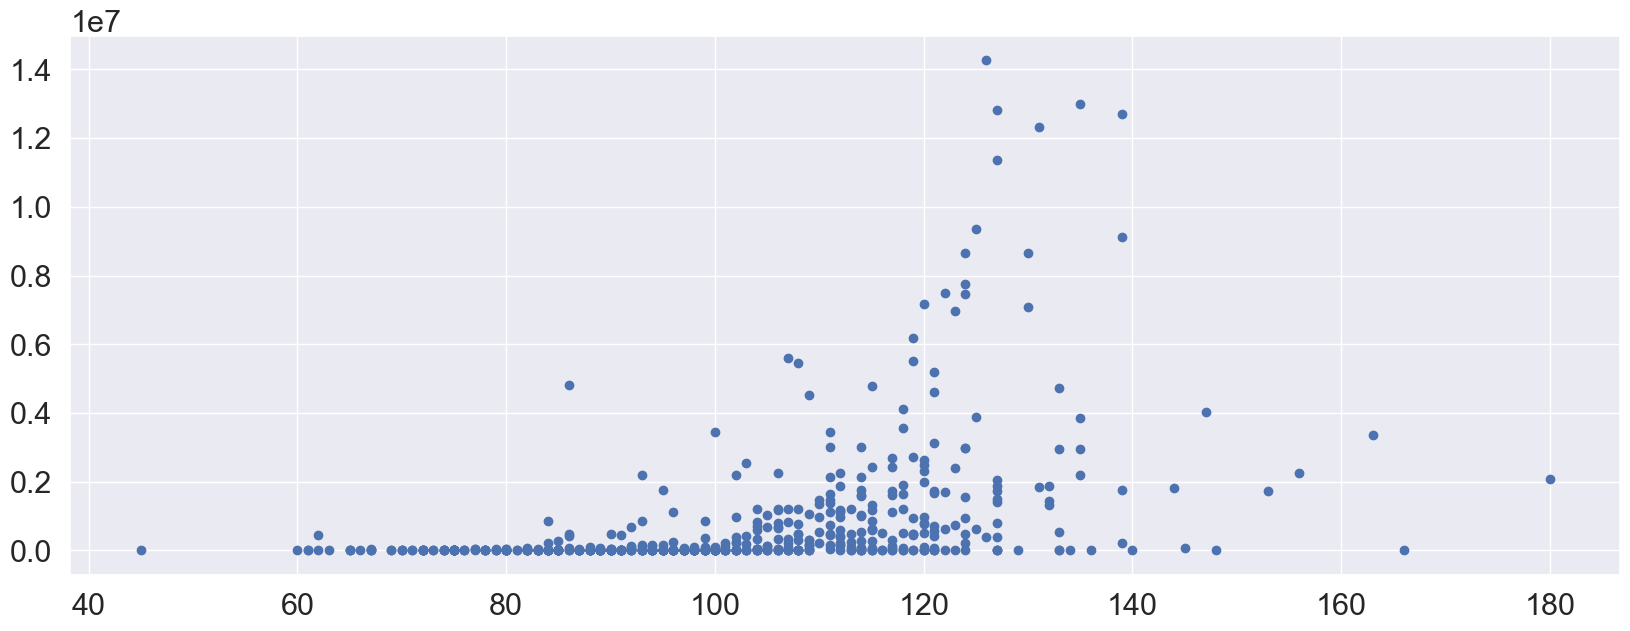

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

plt.scatter(df_train_time['time'], df_train_time['box_off_num'])

plt.show()

- 120~140분 사이의 영화가 많은 관객수를 모은 것을 볼 수 있다.
- 140분 이상은 데이터 수 자체가 너무 적다.

In [144]:
# 100분 이하인 것들만 확인
df_train_time[df_train_time['time'] < 100]

,time,box_off_num
0,45,2919
1,60,328
2,61,71
3,61,188
4,62,152
...,...,...
293,99,600
294,99,542
295,99,13190
296,99,339


In [145]:
# 함수 구현
def time_set(x):
    if x < 100:
        return 1 # 하
    elif x < 121:
        return 2 # 중
    elif x < 141:
        return 3 # 상
    else:
        return 1 # 하

In [146]:
df_train_time['time_en'] = df_train_time['time'].apply(time_set)

In [147]:
pd.pivot_table(df_train_time[['time_en','box_off_num']], index='time_en', aggfunc=['count','sum'])

,count,sum
,box_off_num,box_off_num
time_en,,
1,307,35203954
2,222,167591302
3,71,222113795


- 일단 적용하지는 않고 넘어간다.

## screening_rat
- 상영등급

In [148]:
pd.pivot_table(df_train[['screening_rat','box_off_num']], index=['screening_rat'], aggfunc=['count','sum'])

,count,sum
,box_off_num,box_off_num
screening_rat,,
12세 관람가,102,86188052
15세 관람가,202,251998766
전체 관람가,92,12429242
청소년 관람불가,204,74292991


## director, dir_prev_bfnum, dir_prev_num
- director: 감독 이름
- dir_prev_bfnum: 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수 (단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num: 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수 (단 관객수가 알려지지 않은 영화 제외)
- [가정]
- 감독 이름을 이전 관객 수,와 영화 수와 연관지어 알아보자.
- 메이저, 준메이저 등으로 구분지을 수 있을까?

In [149]:
# 결측률이 50% 이상으로 drop해야 할 것 같다.
print('dir_prev_bfnum의 결측률:', df_train['dir_prev_bfnum'].isnull().sum() / len(df_train['dir_prev_bfnum']))

dir_prev_bfnum의 결측률: 0.55


In [150]:
df_train[(df_train['dir_prev_bfnum'].isnull()) & (df_train['dir_prev_num'] == 0)]

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month
0,기타,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398,2012,11
6,기타,다큐멘터리,104,전체 관람가,이창재,NaN,0,32,5,53526,2013,5
8,기타,뮤지컬,129,전체 관람가,정성복,NaN,0,3,5,4778,2014,9
9,기타,드라마,94,15세 관람가,변성현,NaN,0,138,3,868,2012,3
10,기타,멜로/로맨스,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745,2015,7
...,...,...,...,...,...,...,...,...,...,...,...,...
593,기타,미스터리,97,청소년 관람불가,최위안,NaN,0,5,3,1132,2013,9
594,기타,코미디,94,청소년 관람불가,노진수,NaN,0,37,5,1958,2014,3
597,기타,공포,99,청소년 관람불가,김대현,NaN,0,123,4,2475,2010,9
598,기타,느와르,102,15세 관람가,백운학,NaN,0,431,4,2192525,2015,5


- null값인 데이터의 dir_prev_num, 즉 이전에 참여한 영화의 갯수가 0인 것을 알 수 있다.
- 일반적으로 측정되거나 조사된 값에서 55%가 비어 있다면 유의미한 데이터라고 보기는 어려울 수 있다.
- 하지만, 해당 변수는 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수로, 이전에 영화 제작에 참여하지 않은 신인 감독의 경우 0이 나오게 될 수도 있다.
- 적절히 구간을 나누어 변수로 만들어보자.

<AxesSubplot:title={'center':'Pearson Correalation of Features'}>

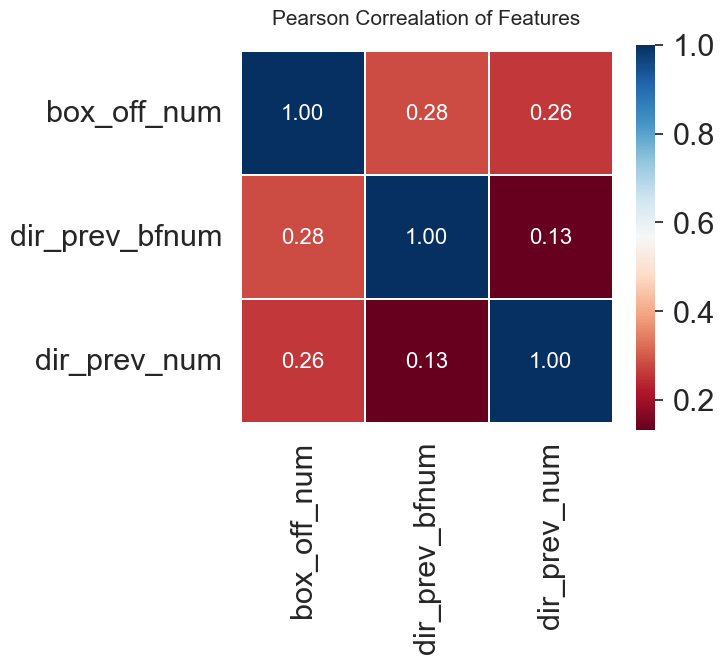

In [151]:
heatmap_data = df_train[['box_off_num','dir_prev_bfnum','dir_prev_num']]
colormap = plt.cm.RdBu
plt.figure(figsize=(6, 5))
plt.title('Pearson Correalation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0
            , square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16}, fmt='.2f')

In [152]:
# 한 명의 감독이 많으면 7개의 영화에 참여했다.
df_train['director'].value_counts().sort_values()

김재환         1
최경석         1
이해준         1
하마구치 류스케    1
오기환         1
           ..
노진수         4
우민호         4
신재호         4
장률          4
홍상수         7
Name: director, Length: 472, dtype: int64

In [153]:
df_train_dir = df_train.groupby('director', as_index=False)['dir_prev_bfnum','dir_prev_num'] \
                .sum().sort_values(by='dir_prev_bfnum', ascending=False).reset_index(drop=True)
df_train_dir

,director,dir_prev_bfnum,dir_prev_num
0,고구마,"17,615,314",1
1,강형철,"16,061,870",3
2,김민석,"8,801,639",2
3,심형래,"7,855,474",1
4,김상진,"7,815,569",8
...,...,...,...
467,백승화,0,0
468,백승기,0,0
469,백동훈,0,0
470,배창호,0,0


In [154]:
df_train_dir.describe()

,dir_prev_bfnum,dir_prev_num
count,472,472
mean,"600,889",1
std,"1,669,276",2
min,0,0
25%,0,0
50%,0,0
75%,"469,236",2
max,"17,615,314",9


In [155]:
df_train_dir[df_train_dir['dir_prev_bfnum'] > 0]

,director,dir_prev_bfnum,dir_prev_num
0,고구마,"17,615,314",1
1,강형철,"16,061,870",3
2,김민석,"8,801,639",2
3,심형래,"7,855,474",1
4,김상진,"7,815,569",8
...,...,...,...
217,배형준,19,2
218,주경중,17,1
219,정용주,8,1
220,이성은,7,1


In [156]:
df_train_dir[df_train_dir['dir_prev_bfnum'] > 0].describe()

,dir_prev_bfnum,dir_prev_num
count,222,222
mean,"1,277,566",2
std,"2,251,710",2
min,1,1
25%,"20,853",1
50%,"511,867",2
75%,"1,523,155",3
max,"17,615,314",9


- 영화감독이 신인인지, 아마추어인지, 프로인지, 거장인지 나누어 보자

In [157]:
# 함수 구현
def director_set(x):
    if x == 0:
        return 1 # 신인
    elif x < 511867:
        return 2 # 아마추어
    elif x < 1523155:
        return 3 # 프로
    else:
        return 4 # 거장

In [158]:
df_train_dir['director_en'] = df_train_dir['dir_prev_bfnum'].apply(director_set)
df_train_dir

,director,dir_prev_bfnum,dir_prev_num,director_en
0,고구마,"17,615,314",1,4
1,강형철,"16,061,870",3,4
2,김민석,"8,801,639",2,4
3,심형래,"7,855,474",1,4
4,김상진,"7,815,569",8,4
...,...,...,...,...
467,백승화,0,0,1
468,백승기,0,0,1
469,백동훈,0,0,1
470,배창호,0,0,1


- 이렇게 구분하는 경우 train 데이터에서는 잘 구분될 수 있지만 새로운 데이터에서는 의미가 없을 수 있다.
- 거장 감독이지만 train set에 없다면 새로운 데이터를 검증하기 어려우며, 신인 감독인 경우에도 마찬가지일 수 있다.

In [159]:
# director drop

df_train = df_train.drop('director', axis=1)
df_test = df_test.drop('director', axis=1)

In [160]:
# dir_prev_bfnum drop

df_train = df_train.drop('dir_prev_bfnum', axis=1)
df_test = df_test.drop('dir_prev_bfnum', axis=1)

In [161]:
# dir_prev_num 대기

# df_train = df_train.drop('dir_prev_num', axis=1)
# df_test = df_test.drop('dir_prev_num', axis=1)

## num_staff
- 스태프 수
- 스태프 수가 많을수록 제작비가 많이 들어갔다는 의미이니, 관객을 많이 모을 확률이 높은걸까?
- 스태프 수에 따라 소형, 중형, 대형으로 나누어 보자

In [162]:
df_train_staff = df_train[['num_staff','box_off_num']]
df_train_staff

,num_staff,box_off_num
0,91,23398
1,387,7072501
2,343,6959083
3,20,217866
4,251,483387
...,...,...
595,510,1475091
596,286,1716438
597,123,2475
598,431,2192525


In [163]:
df_train_staff.describe()

,num_staff,box_off_num
count,600,600
mean,151,"708,182"
std,166,"1,828,006"
min,0,1
25%,17,"1,297"
50%,82,"12,591"
75%,264,"479,887"
max,869,"14,262,766"


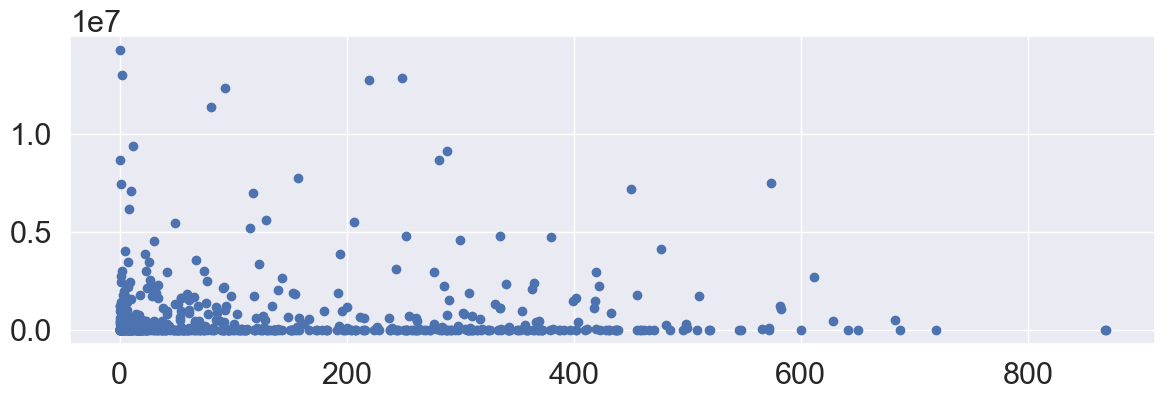

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

plt.scatter(df_train_staff['num_staff'], df_train_time['box_off_num'])

plt.show()

## num_actor
- 주연 배우 수

In [165]:
df_train[['num_actor','box_off_num']]

,num_actor,box_off_num
0,2,23398
1,3,7072501
2,4,6959083
3,6,217866
4,2,483387
...,...,...
595,7,1475091
596,6,1716438
597,4,2475
598,4,2192525


In [166]:
df_train['num_actor'].describe()

count   600
mean      4
std       2
min       0
25%       2
50%       3
75%       4
max      25
Name: num_actor, dtype: float64

- 주연 배우의 수는 대부분 2명 수준

## box_off_num(Target)

In [167]:
# df_train['box_off_num'] = np.log1p(df_train['box_off_num'])

# 학습 데이터 준비

## 데이터 확인

In [168]:
df_train.shape, df_test.shape

((600, 10), (243, 9))

In [169]:
df_train.head(3)

,distributor,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num,year,month
0,기타,액션,96,청소년 관람불가,0,91,2,23398,2012,11
1,기타,느와르,130,청소년 관람불가,2,387,3,7072501,2015,11
2,기타,액션,123,15세 관람가,4,343,4,6959083,2013,6


In [170]:
df_test.head(3)

,distributor,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,year,month
0,기타,느와르,125,청소년 관람불가,2,304,3,2010,1
1,기타,멜로/로맨스,113,12세 관람가,4,275,3,2010,1
2,기타,드라마,115,12세 관람가,3,419,7,2010,1


## 원 핫 인코딩

In [171]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [172]:
# object_columns = df_train.dtypes[df_train.dtypes == 'object'].index.tolist()

In [173]:
# for column in object_columns:
#     df_train[column] = pd.factorize(df_train[column])[0]

In [174]:
# object_columns = df_test.dtypes[df_test.dtypes == 'object'].index.tolist()

In [175]:
# for column in object_columns:
#     df_test[column] = pd.factorize(df_test[column])[0]

# Modeling - Prediction - Submission

### Modeling

In [176]:
X = df_train.drop(['box_off_num'],axis= 1)

In [177]:
y = df_train['box_off_num']

In [420]:
xgb = XGBRegressor(
            n_estimators=170, ## 붓스트랩 샘플 개수 또는 base_estimator 개수
            max_depth=5, ## 개별 나무의 최대 깊이
            gamma = 0, ## gamma
            eta = 0.08,
            subsample = 0.7,
            min_child_weight = 1,
            importance_type='gain', ## gain, weight, cover, total_gain, total_cover
            reg_lambda = 1, ## tuning parameter of l2 penalty
            random_state=100
        ).fit(X,y)

In [421]:
scores = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('RMSE average: %0.3f' % (rmse.mean()))
print(xgb.score(X, y))

RMSE: [1065908.054 1735002.705 1055520.363 1833909.89  1937456.39 ]
RMSE average: 1525559.481
0.9824919643016636


In [422]:
## 변수 중요도
for i, feature in enumerate(df_test.columns):
    print(f'{feature} : {xgb.feature_importances_[i]}')

time : 0.072654128074646
dir_prev_num : 0.03723081946372986
num_staff : 0.07834890484809875
num_actor : 0.08566232770681381
year : 0.06455722451210022
month : 0.04551791399717331
distributor_기타 : 0.0
genre_SF : 0.05038221925497055
genre_공포 : 0.034897949546575546
genre_느와르 : 0.040393974632024765
genre_다큐멘터리 : 0.015102469362318516
genre_드라마 : 0.06224563345313072
genre_멜로/로맨스 : 0.012665827758610249
genre_뮤지컬 : 0.0
genre_미스터리 : 0.04000931233167648
genre_서스펜스 : 0.00029691430972889066
genre_애니메이션 : 0.0042205131612718105
genre_액션 : 0.04025225713849068
genre_코미디 : 0.10695591568946838
screening_rat_12세 관람가 : 0.013443228788673878
screening_rat_15세 관람가 : 0.10502297431230545
screening_rat_전체 관람가 : 0.009791476652026176
screening_rat_청소년 관람불가 : 0.08034799247980118


### Prediction

In [423]:
prediction = xgb.predict(df_test)

### Submission

In [424]:
submission = pd.read_csv('data/submission.csv')
submission.head(2)

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0


In [425]:
submission['box_off_num'] = prediction
submission.head(2)

,title,box_off_num
0,용서는 없다,"1,890,034"
1,아빠가 여자를 좋아해,"1,608,540"


In [426]:
submission_title = 'v6'+'_movie_submission_'+datetime.datetime.now().strftime("%y%m%d_%H%M")
submission.to_csv(submission_title+'.csv',index = False)
'-----' + submission_title + ' saved -----'

'-----v6_movie_submission_230402_1659 saved -----'